# Load model

# RABD Benchmark

#### AbFlow

In [4]:
# RABD Benchmark: Design *num_designs* complexes from PDB files in *pdb_dir* and compute metrics

import os
import torch
import pandas as pd
from datetime import datetime
from abflow.constants import initialize_constants
from abflow.data.process_pdb import process_pdb_to_lmdb, process_lmdb_chain, add_features, fill_missing_atoms
from abflow.model.metrics import AbFlowMetrics
from abflow.model.utils import concat_dicts
from abflow.constants import chain_id_to_index, aa1_name_to_index

def process_pdb_to_data_dict(pdb_file, heavy_chain_id, light_chain_id, antigen_chain_ids, scheme):
    """Process PDB file into input data dictionary."""
    # Prepare output path for the fixed PDB
    fixed_pdb_file = pdb_file.replace(".pdb", "_fixed.pdb")
    fill_missing_atoms(pdb_file, fixed_pdb_file)

    # Process PDB to data dictionary
    data = process_pdb_to_lmdb(
        fixed_pdb_file, model_id=0,
        heavy_chain_id=heavy_chain_id, light_chain_id=light_chain_id,
        antigen_chain_ids=antigen_chain_ids, scheme=scheme
    )
    data_dict = process_lmdb_chain(data)
    data_dict.update(add_features(data_dict))
    
    return data_dict, fixed_pdb_file

def generate_complexes(data_dict, num_designs, batch_size, seed):
    """Generate complexes from input data dictionary."""
    pred_data_dicts = []
    for _ in range(0, num_designs, batch_size):
        current_batch_size = min(batch_size, num_designs - len(pred_data_dicts))
        true_data_dict = datamodule.collate([data_dict.copy()] * current_batch_size)
        for key in true_data_dict:
            true_data_dict[key] = true_data_dict[key].to(device)

        pred_data_dict = model._generate_complexes(true_data_dict, seed=seed)
        pred_data_dicts.append(pred_data_dict)

    # Combine all predictions into one dictionary
    pred_data_dict = concat_dicts(pred_data_dicts)

    return pred_data_dict

def copy_data_dict(data_dict, num_designs):

    true_data_dict = datamodule.collate([data_dict.copy()] * num_designs)
    for key in true_data_dict:
        true_data_dict[key] = true_data_dict[key].to(device)

    return true_data_dict

def compute_metrics(true_data_dict, pred_data_dict):
    """Compute metrics for the generated complexes."""

    # Compute metrics
    metrics = AbFlowMetrics()
    metrics_dict = metrics(pred_data_dict, true_data_dict)

    # Aggregate metrics into a dictionary of mean values
    aggregated_metrics = {k: v.mean().item() for k, v in metrics_dict.items()}
    return aggregated_metrics

def cleanup_fixed_file(fixed_pdb_file):
    """Remove the fixed PDB file to keep the directory clean."""
    if os.path.exists(fixed_pdb_file):
        os.remove(fixed_pdb_file)
        print(f"Temporary file removed: {fixed_pdb_file}")

def evaluate_single_pdb(pdb_file, heavy_chain_id, light_chain_id, antigen_chain_ids, scheme, num_designs, batch_size, seed):
    """Full pipeline to process PDB, generate complexes, compute metrics, and clean up."""

    try:
        data_dict, fixed_pdb_file = process_pdb_to_data_dict(pdb_file, heavy_chain_id, light_chain_id, antigen_chain_ids, scheme)
        pred_data_dict = generate_complexes(data_dict, num_designs, batch_size, seed)
        true_data_dict = copy_data_dict(data_dict, num_designs)
        metrics = compute_metrics(true_data_dict, pred_data_dict)
        return metrics
    finally:
        cleanup_fixed_file(fixed_pdb_file)

def evaluate_mutated_pdb(pdb_file, parent_info, mutated_info, heavy_chain_id, light_chain_id, antigen_chain_ids, scheme, results_dir, num_designs, batch_size, seed):
    """
    Evaluates a PDB file with mutated sequences provided in mutated_info and saves metrics to a CSV file,
    ensuring only mutations with the same length as the parent sequence are processed.

    :param pdb_file: Path to the PDB file.
    :param parent_info: Path to the CSV file containing parent sequence information.
    :param mutated_info: Path to the CSV file containing mutated sequences and metadata.
    :param heavy_chain_id: Chain ID for the heavy chain.
    :param light_chain_id: Chain ID for the light chain.
    :param antigen_chain_ids: List of chain IDs for antigens.
    :param scheme: Antibody numbering scheme.
    :param results_dir: Directory to save the results CSV file.

    :return: None
    """
    # Load parent sequence information
    parent_df = pd.read_csv(parent_info)
    parent_heavy_sequence = parent_df["Heavy"].iloc[0]
    parent_light_sequence = parent_df["Light"].iloc[0]
    parent_hcdr3_length = len(parent_df["HCDR3"].iloc[0])

    # Load mutated sequence information
    mutated_df = pd.read_csv(mutated_info)

    # Filter mutations to ensure the same length as the parent HCDR3
    mutated_df = mutated_df[mutated_df["HCDR3"].str.len() == parent_hcdr3_length]

    # Process the original PDB to input data dictionary
    data_dict, fixed_pdb_file = process_pdb_to_data_dict(
        pdb_file, heavy_chain_id, light_chain_id, antigen_chain_ids, scheme
    )

    # Generate complexes
    pred_data_dict = generate_complexes(data_dict, num_designs, batch_size, seed)

    # Add a column for the "likelihood/redesign" metric
    mutated_df["likelihood"] = None

    try:
        # Iterate through mutations in the filtered mutated_info CSV
        for idx, row in mutated_df.iterrows():
            mutated_data_dict = data_dict.copy()

            mutated_heavy_sequence = parent_heavy_sequence.replace(parent_df["HCDR3"].iloc[0], row["HCDR3"])
            mutated_light_sequence = parent_light_sequence  # Assuming no mutations in the light chain

            # Replace sequences in data_dict
            heavy_indices = (data_dict["chain_type"] == chain_id_to_index["heavy"])
            light_indices = (data_dict["chain_type"] == chain_id_to_index["light_lambda"]) | (data_dict["chain_type"] == chain_id_to_index["light_kappa"])

            mutated_data_dict["res_type"][heavy_indices] = torch.tensor(
                [aa1_name_to_index[aa] for aa in mutated_heavy_sequence],
                dtype=torch.long,
                device=data_dict["res_type"].device,
            )
            mutated_data_dict["res_type"][light_indices] = torch.tensor(
                [aa1_name_to_index[aa] for aa in mutated_light_sequence],
                dtype=torch.long,
                device=data_dict["res_type"].device,
            )

            mutated_data_dict = copy_data_dict(mutated_data_dict, num_designs)

            # Compute metrics
            metrics = compute_metrics(mutated_data_dict, pred_data_dict)

            # Extract the "likelihood/redesign" metric
            likelihood = metrics.get("likelihood/redesign", float("nan"))

            # Store the metric in the DataFrame
            mutated_df.at[idx, "likelihood"] = likelihood

        # Save the filtered results to a new CSV file
        os.makedirs(results_dir, exist_ok=True)
        output_csv_path = os.path.join(results_dir, "absci_her2_zs_likelihood.csv")
        mutated_df.to_csv(output_csv_path, index=False)
        print(f"Filtered results saved to: {output_csv_path}")

    finally:
        cleanup_fixed_file(fixed_pdb_file)


# Absci affinity benchmark

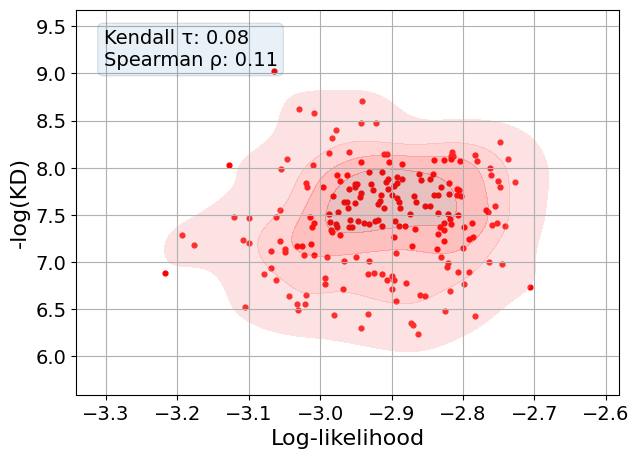

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kendalltau, spearmanr

def plot_correlation_scatter(
    log_likelihood: np.ndarray, log_kd: np.ndarray, save_path: str = None
):
    """
    Create a scatter plot with a density contour and display Kendall and Spearman correlations.

    :param log_likelihood: Array of log-likelihood values.
    :param log_kd: Array of -log(KD) values.
    :param save_path: Optional path to save the plot. If None, the plot will be displayed.
    """

    plt.figure(figsize=(7, 5))
    plt.scatter(log_likelihood, log_kd, color="red", s=12)
    sns.kdeplot(x=log_likelihood, y=log_kd, fill=True, color="red", alpha=0.3, levels=5)

    kendall_tau, _ = kendalltau(log_likelihood, log_kd)
    spearman_rho, _ = spearmanr(log_likelihood, log_kd)

    plt.text(
        0.05,
        0.95,
        f"Kendall τ: {kendall_tau:.2f}\nSpearman ρ: {spearman_rho:.2f}",
        transform=plt.gca().transAxes,
        fontsize=14,
        verticalalignment="top",
        bbox=dict(boxstyle="round", alpha=0.1),
    )
    plt.xlabel("Log-likelihood", fontsize=16)
    plt.ylabel("-log(KD)", fontsize=16)
    plt.tick_params(axis="x", labelsize=14)
    plt.tick_params(axis="y", labelsize=14)
    plt.grid(True)

    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
    else:
        plt.show()

    plt.close()
    
# Load the saved data
data_path = "./AbFlow/results/absci_her2_zs_likelihood.csv"
data = pd.read_csv(data_path)

# Extract log-likelihood and -log(KD) as numpy arrays
log_likelihood = data["likelihood"].to_numpy()
log_kd = data["-log(KD (M))"].to_numpy()

# Plot the correlation
plot_correlation_scatter(log_likelihood, log_kd)

# Baseline